# IMPORT LIBRARY

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder



# DATA PREPARATION

In [8]:
from google.colab import files
files.upload()  # upload kaggle.json
import os
import zipfile

# Buat folder .kaggle dan pindahkan file ke sana
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json  # beri permission

!kaggle datasets download -d ealaxi/paysim1

with zipfile.ZipFile("paysim1.zip", 'r') as zip_ref:
    zip_ref.extractall("paysim_data")


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/ealaxi/paysim1
License(s): CC-BY-SA-4.0
 65% 115M/178M [00:00<00:00, 1.20GB/s]
100% 178M/178M [00:00<00:00, 736MB/s] 


In [43]:
# Load dataset
df = pd.read_csv('/content/paysim_data/PS_20174392719_1491204439457_log.csv')

# Tampilkan 5 data awal
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# EXPLORATORY DATA ANALYSIS (EDA)

In [45]:
# === Feature Engineering: AML Behavior ===
df['count_txn_by_orig'] = df.groupby('nameOrig')['amount'].transform('count')
df['sum_txn_by_orig'] = df.groupby('nameOrig')['amount'].transform('sum')
df['avg_amount_by_orig'] = df.groupby('nameOrig')['amount'].transform('mean')
df['count_unique_dest'] = df.groupby('nameOrig')['nameDest'].transform('nunique')
df['count_txn_by_dest'] = df.groupby('nameDest')['amount'].transform('count')


In [46]:
# Drop kolom yang tidak dipakai
df_model = df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud', 'step'], axis=1)


In [47]:
# Encode 'type' (categorical) ke numerik
df_model['type'] = LabelEncoder().fit_transform(df_model['type'])

# Pisahkan fitur dan target
X = df_model.drop('isFraud', axis=1)
y = df_model['isFraud']

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# MODELING

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


In [49]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [50]:
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


# EVALUASI

Akurasi: 0.9616

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98   1270881
           1       0.03      0.85      0.05      1643

    accuracy                           0.96   1272524
   macro avg       0.51      0.91      0.52   1272524
weighted avg       1.00      0.96      0.98   1272524



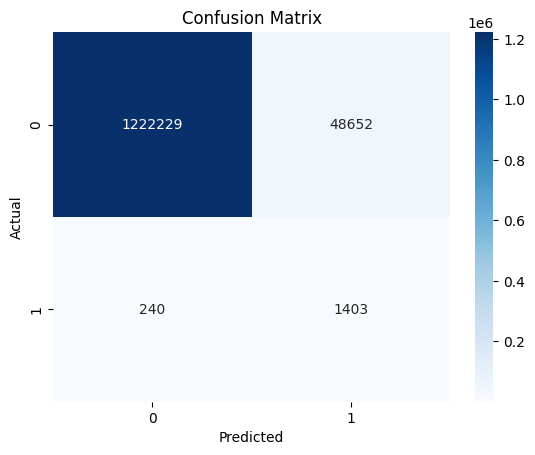

In [51]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Prediksi
y_pred = model.predict(X_test)

# Akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi: {accuracy:.4f}")

# Laporan Lengkap
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



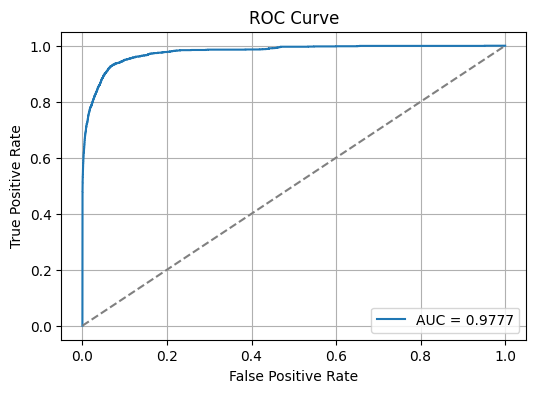

In [84]:
from sklearn.metrics import roc_curve, auc

y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


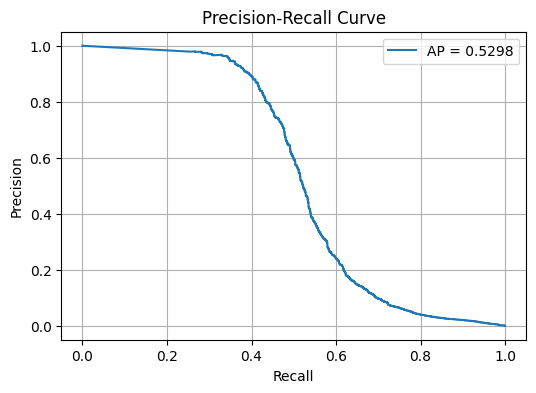

In [85]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f"AP = {ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.legend()
plt.show()


In [86]:
from sklearn.metrics import classification_report, roc_auc_score

# Prediksi di training
y_train_pred = model.predict(X_train)
y_train_proba = model.predict_proba(X_train)[:, 1]

print("=== Training Evaluation ===")
print(classification_report(y_train, y_train_pred))
print(f"AUC Train: {roc_auc_score(y_train, y_train_proba):.4f}")


=== Training Evaluation ===
              precision    recall  f1-score   support

           0       1.00      0.96      0.98   5083526
           1       0.03      0.86      0.05      6570

    accuracy                           0.96   5090096
   macro avg       0.51      0.91      0.52   5090096
weighted avg       1.00      0.96      0.98   5090096

AUC Train: 0.9752


In [87]:
# Prediksi di testing
y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)[:, 1]

print("=== Testing Evaluation ===")
print(classification_report(y_test, y_test_pred))
print(f"AUC Test: {roc_auc_score(y_test, y_test_proba):.4f}")


=== Testing Evaluation ===
              precision    recall  f1-score   support

           0       1.00      0.96      0.98   1270881
           1       0.03      0.85      0.05      1643

    accuracy                           0.96   1272524
   macro avg       0.51      0.91      0.52   1272524
weighted avg       1.00      0.96      0.98   1272524

AUC Test: 0.9777


In [53]:
import joblib
# Step 3: Simpan model dan scaler
joblib.dump(model, 'fraud_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [54]:
from sklearn.preprocessing import LabelEncoder

# Fit LabelEncoder pada kolom 'type'
label_encoder = LabelEncoder()
df['type'] = label_encoder.fit_transform(df['type'])

# Simpan objek yang sudah di-fit
joblib.dump(label_encoder, 'label_encoder.pkl')  # ✅ BENAR


['label_encoder.pkl']

# DEPLOYMENT (Opsional)

In [68]:
import pandas as pd
import joblib
import numpy as np

def prediksi_fraud(
    jenis_transaksi=None,
    jumlah=None,
    saldo_awal_pengirim=None,
    saldo_akhir_pengirim=None,
    saldo_awal_penerima=None,
    saldo_akhir_penerima=None,
    jumlah_transaksi_pengirim=None,
    total_uang_dikirim_pengirim=None,
    rata_rata_pengiriman_pengirim=None,
    jumlah_tujuan_unik=None,
    jumlah_transaksi_penerima=None
):
    # Muat model dan preprocessor
    model = joblib.load('fraud_model.pkl')
    scaler = joblib.load('scaler.pkl')
    label_encoder = joblib.load('label_encoder.pkl')

    # Nilai default jika ada yang kosong
    nilai_default = {
        'jenis_transaksi': 'TRANSFER',
        'jumlah': 0.0,
        'saldo_awal_pengirim': 0.0,
        'saldo_akhir_pengirim': 0.0,
        'saldo_awal_penerima': 0.0,
        'saldo_akhir_penerima': 0.0,
        'jumlah_transaksi_pengirim': 0,
        'total_uang_dikirim_pengirim': 0.0,
        'rata_rata_pengiriman_pengirim': 0.0,
        'jumlah_tujuan_unik': 0,
        'jumlah_transaksi_penerima': 0
    }

    inputan = {
        'jenis_transaksi': jenis_transaksi,
        'jumlah': jumlah,
        'saldo_awal_pengirim': saldo_awal_pengirim,
        'saldo_akhir_pengirim': saldo_akhir_pengirim,
        'saldo_awal_penerima': saldo_awal_penerima,
        'saldo_akhir_penerima': saldo_akhir_penerima,
        'jumlah_transaksi_pengirim': jumlah_transaksi_pengirim,
        'total_uang_dikirim_pengirim': total_uang_dikirim_pengirim,
        'rata_rata_pengiriman_pengirim': rata_rata_pengiriman_pengirim,
        'jumlah_tujuan_unik': jumlah_tujuan_unik,
        'jumlah_transaksi_penerima': jumlah_transaksi_penerima
    }

    # Isi otomatis nilai kosong
    for k in inputan:
        if inputan[k] is None or (isinstance(inputan[k], float) and np.isnan(inputan[k])):
            print(f"⚠️  Input '{k.replace('_', ' ').capitalize()}' kosong. Diisi otomatis dengan: {nilai_default[k]}")
            inputan[k] = nilai_default[k]

    # Encode jenis transaksi
    jenis_encoded = label_encoder.transform([inputan['jenis_transaksi']])[0]

    # Buat dataframe input
    data_input = pd.DataFrame([{
        'type': jenis_encoded,
        'amount': inputan['jumlah'],
        'oldbalanceOrg': inputan['saldo_awal_pengirim'],
        'newbalanceOrig': inputan['saldo_akhir_pengirim'],
        'oldbalanceDest': inputan['saldo_awal_penerima'],
        'newbalanceDest': inputan['saldo_akhir_penerima'],
        'count_txn_by_orig': inputan['jumlah_transaksi_pengirim'],
        'sum_txn_by_orig': inputan['total_uang_dikirim_pengirim'],
        'avg_amount_by_orig': inputan['rata_rata_pengiriman_pengirim'],
        'count_unique_dest': inputan['jumlah_tujuan_unik'],
        'count_txn_by_dest': inputan['jumlah_transaksi_penerima']
    }])

    # Scaling
    data_scaled = scaler.transform(data_input)

    # Prediksi
    hasil_prediksi = model.predict(data_scaled)[0]
    probabilitas_fraud = model.predict_proba(data_scaled)[0][1]

    print("\n=== Hasil Prediksi Transaksi ===")
    print(f"Jenis Transaksi         : {inputan['jenis_transaksi']}")
    print(f"Prediksi                : {'🛑 PENCUCIAN UANG (FRAUD)' if hasil_prediksi == 1 else '✅ TRANSAKSI NORMAL'}")
    print(f"Probabilitas Fraud (%)  : {probabilitas_fraud * 100:.2f}%")


In [82]:
from pickle import NONE
prediksi_fraud(
    jenis_transaksi='TRANSFER',
    jumlah=700000.0,
    saldo_awal_pengirim=900000.0,
    saldo_akhir_pengirim=300000.0,
    saldo_awal_penerima=None,
    saldo_akhir_penerima=900000.0,
    jumlah_transaksi_pengirim=None,
    total_uang_dikirim_pengirim=None,
    rata_rata_pengiriman_pengirim=None,
    jumlah_tujuan_unik=None,
    jumlah_transaksi_penerima=100
)


⚠️  Input 'Saldo awal penerima' kosong. Diisi otomatis dengan: 0.0
⚠️  Input 'Jumlah transaksi pengirim' kosong. Diisi otomatis dengan: 0
⚠️  Input 'Total uang dikirim pengirim' kosong. Diisi otomatis dengan: 0.0
⚠️  Input 'Rata rata pengiriman pengirim' kosong. Diisi otomatis dengan: 0.0
⚠️  Input 'Jumlah tujuan unik' kosong. Diisi otomatis dengan: 0

=== Hasil Prediksi Transaksi ===
Jenis Transaksi         : TRANSFER
Prediksi                : 🛑 PENCUCIAN UANG (FRAUD)
Probabilitas Fraud (%)  : 100.00%
